In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle

from game import *
from agents import *
from checkers import *

In [11]:
# generate opponents using opposite reward
ab1_r = AlphaBetaAgent(1, reward_direction=-1)
ab2_r = AlphaBetaAgent(2, reward_direction=-1)
ab3_r = AlphaBetaAgent(3, reward_direction=-1)     
rand_agent = RandomAgent()


n_features = 34
feature_func = checkers_features_augmented

# n_features = 12
# feature_func = checkers_features_simple

reward_function = checkers_reward

max_moves = 500
np.random.seed(12)
initial_weights = np.random.normal(size=n_features)
first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0.01, gamma=0.7, epsilon=0.35, is_learning_agent=True, weights=initial_weights)


# set reverse rule (in ClassicGameRules.new_game)
reverse = True
quiet = True

In [3]:
first_agent.start_episode()
first_agent.temporal_difference

[]

In [12]:
first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)



Oppn: Rand agent, RL agent play first win = True draw = False moves = 39


In [15]:
first_agent.episode_td_history,first_agent.episode_reward_history

([24.6565256666072,
  2.6100636188767643,
  -22.90314166494003,
  -2.6909550423126585,
  -4.873591618124443,
  18.20862279188808,
  -21.166392547119568,
  -5.9502065662693475,
  21.37869716755476,
  -1.1392422611248698,
  6.772211326203377,
  16.85657551971269,
  -3.631709657668953,
  16.19576018156413,
  7.481218515092407,
  -4.097961993587561,
  2.232164696187841,
  13.191252246070126,
  6.13598735072319,
  2.2382975236846314,
  10.241830539374796,
  -1.9334368780576796,
  8.942238351508275,
  2.715648557464238,
  -3.714532270644624,
  1.5005446006139138,
  22.36123667107518,
  -1.7360792600598896,
  -1.093762273254187,
  -7.14291949283509,
  0.7207784499038143,
  -8.93276060387816,
  19.477655135079793,
  3.5919484247573723,
  1.4262722536487757,
  -4.695420832469185,
  -2.7146638388506346,
  5.662917956658985,
  -9.543566692400912,
  2.091548252716931,
  1.1722603659080464,
  7.730256875773775,
  0.8371660117434431,
  -2.0752756984367347,
  5.383096702018447,
  2.0267951562355306,


In [14]:
max_random_start_depth=2
n_test_games=100
max_moves = 500
test_results = []
test_draws=[]

ab1 = AlphaBetaAgent(1)

for n in range(n_test_games):
    if n%10 ==0:print(n)
    first_agent_turn = bool(np.random.binomial(1,0.5))
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent,ab1, first_agent_turn, quiet=quiet)
    # random start
    for _ in range(np.random.choice(max_random_start_depth)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)

    num_moves, game_state = game.run()
    test_results.append(game_state.is_first_agent_win())
    test_draws.append(game_state.max_moves_done)
np.mean(np.array(test_results)),np.mean(np.array(test_draws))

0
10
20
30
40
50
60
70
80
90


(0.58, 0.03)

In [19]:
n_features = 34
feature_func = checkers_features_augmented

reward_function = checkers_reward

max_moves = 500
np.random.seed(12)
initial_weights = np.random.normal(size=n_features)

ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()

quiet = True
n_train_games = 200
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
initial_alpha = 0.01
initial_epsilon = 0.35

first_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, 
                                 alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                 is_learning_agent=True, weights=initial_weights)
second_agent_list = [ab1, ab2, ab3, rand_agent]
all_results = []
all_draws = []
all_oppn_idx = []
all_weights = []
all_rewards = []
all_num = []
test_results_rand = []
test_results_1 = []
test_results_2 = []
test_results_3 = []
test_draws_rand = []
test_draws_1 = []
test_draws_2 = []
test_draws_3 = []

# pre-training test
this_test_results_rand = []
this_test_results_1 = []
this_test_results_2 = []
this_test_results_3 = []

this_test_draws_rand = []
this_test_draws_1 = []
this_test_draws_2 = []
this_test_draws_3 = []

# training 
for n in range(n_train_games):    
    # change alpha and epsilon after n_decay games
    if n%n_decay == n_decay-1:
        first_agent.alpha = max([0.95*first_agent.alpha, 1e-4])
        first_agent.epsilon = max([0.95*first_agent.epsilon, 0.05])
        print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
        print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)
    
    if n%50 == 0: print(n)
    # train against randomly selected agent
    first_agent_turn = bool(np.random.binomial(1,0.5))
    
    second_agent_idx = np.random.choice(len(second_agent_list))  
    all_oppn_idx.append(second_agent_idx)
    second_agent = second_agent_list[second_agent_idx]
    
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    
    
    # random start
    for _ in range(np.random.choice(max_random_start_depth_train)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)
        
    num_moves, game_state = game.run()
    
    all_num.append(num_moves)
    all_rewards.append(first_agent.episode_rewards)
    all_results.append(game_state.is_first_agent_win())
    all_draws.append((game_state.max_moves_done))
    all_weights.append(first_agent.weights.copy())
        
    if n%test_frequency == test_frequency-1:
        
        this_test_results_rand = []
        this_test_results_1 = []
        this_test_results_2 = []
        this_test_results_3 = []
        
        this_test_draws_rand = []
        this_test_draws_1 = []
        this_test_draws_2 = []
        this_test_draws_3 = []
        
        for n in range(n_games_test):
            current_epislon = first_agent.epsilon
            test_agent = SarsaLearningAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=current_epislon, is_learning_agent=False, weights=all_weights[-1])
            # play against ab1
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)
            
            # random start
            random_start_spots = game.game_state.board.spots
            for _ in range(np.random.choice(max_random_start_depth_test)*2):
                possible_moves = game.game_state.board.get_possible_next_moves()
                next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                game.game_state.board.make_move(next_move, switch_player_turn=True)
                random_start_spots = game.game_state.board.spots
        
            num_moves, game_state = game.run()
            this_test_results_1.append(game_state.is_first_agent_win())
            this_test_draws_1.append(game_state.max_moves_done)
            
#             # play against ab2
#             first_agent_turn = bool(np.random.binomial(1,0.5))
#             rules = ClassicGameRules(max_moves=max_moves)
#             game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
#             game.game_state.board.spots = random_start_spots # set start board position to the same random start
#             num_moves, game_state = game.run()
#             this_test_results_2.append(game_state.is_first_agent_win())
#             this_test_draws_2.append(game_state.max_moves_done)
            
#             # play against ab3
#             first_agent_turn = bool(np.random.binomial(1,0.5))
#             rules = ClassicGameRules(max_moves=max_moves)
#             game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
#             game.game_state.board.spots = random_start_spots # set start board position to the same random start
#             num_moves, game_state = game.run()
#             this_test_results_3.append(game_state.is_first_agent_win())
#             this_test_draws_3.append(game_state.max_moves_done)
            
            # play against random agent
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_rand.append(game_state.is_first_agent_win())
            this_test_draws_rand.append(game_state.max_moves_done)
            
        test_results_1.append(np.mean(np.array(this_test_results_1)))
#         test_results_2.append(np.mean(np.array(this_test_results_2)))
#         test_results_3.append(np.mean(np.array(this_test_results_3)))
        test_results_rand.append(np.mean(np.array(this_test_results_rand)))
        
        test_draws_1.append(np.mean(np.array(this_test_draws_1)))
#         test_draws_2.append(np.mean(np.array(this_test_draws_2)))
#         test_draws_3.append(np.mean(np.array(this_test_draws_3)))
        test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))
        
#         print('wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
#         print('draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])    
        print('wins = ',test_results_1[-1],test_results_rand[-1])    
        print('draws = ',test_draws_1[-1],test_draws_rand[-1])    

0
9 Fraction of wins =  0.1111111111111111 Fraction of draws =  0.1111111111111111
9 alpha =  0.0095 epsilon =  0.33249999999999996
wins =  0.0 0.1
draws =  0.2 0.0
19 Fraction of wins =  0.2 Fraction of draws =  0.0
19 alpha =  0.009025 epsilon =  0.31587499999999996
wins =  0.9 1.0
draws =  0.0 0.0
29 Fraction of wins =  0.2 Fraction of draws =  0.1
29 alpha =  0.00857375 epsilon =  0.30008124999999997
wins =  0.9 1.0
draws =  0.1 0.0
39 Fraction of wins =  0.2 Fraction of draws =  0.2
39 alpha =  0.0081450625 epsilon =  0.28507718749999994
wins =  0.9 1.0
draws =  0.0 0.0
49 Fraction of wins =  0.4 Fraction of draws =  0.1
49 alpha =  0.007737809374999999 epsilon =  0.27082332812499993
wins =  0.7 1.0
draws =  0.3 0.0
50
59 Fraction of wins =  0.3 Fraction of draws =  0.0
59 alpha =  0.007350918906249998 epsilon =  0.2572821617187499
wins =  0.8 1.0
draws =  0.2 0.0
69 Fraction of wins =  0.3 Fraction of draws =  0.1
69 alpha =  0.006983372960937498 epsilon =  0.24441805363281238
wi

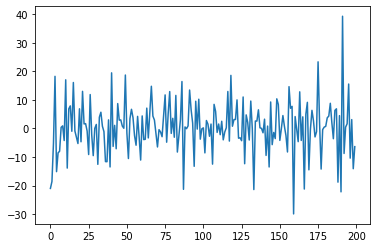

In [26]:
plt.plot(first_agent.episode_td_history)

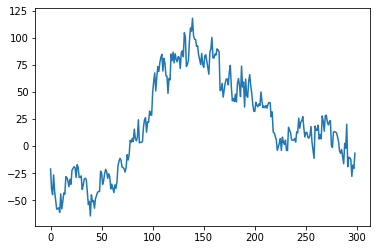

In [27]:
plt.plot(np.convolve(np.array(first_agent.episode_td_history),np.ones(100)))

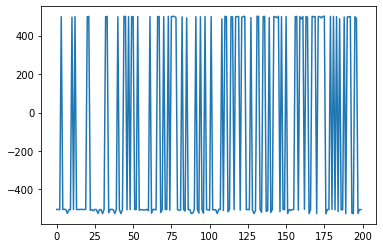

In [21]:
plt.plot(first_agent.episode_reward_history)

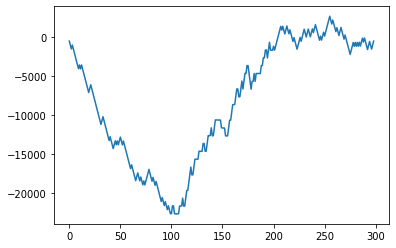

In [24]:
plt.plot(np.convolve(np.array(first_agent.episode_reward_history),np.ones(100)))

In [8]:
max_random_start_depth=2
n_test_games=100
max_moves = 500
test_results = []
test_draws=[]

for n in range(n_test_games):
    if n%10 ==0:print(n)
    first_agent_turn = bool(np.random.binomial(1,0.5))
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(ab2_r,ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
    # random start
    for _ in range(np.random.choice(max_random_start_depth)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)

    num_moves, game_state = game.run()
    test_results.append(game_state.is_first_agent_win())
    test_draws.append(game_state.max_moves_done)
np.mean(np.array(test_results)),np.mean(np.array(test_draws))

0
10
20
30
40
50
60
70
80
90


(0.01, 0.41)

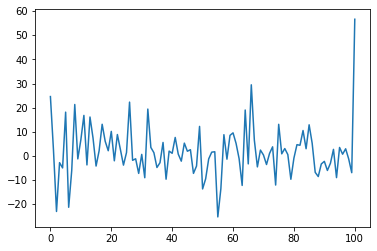

In [17]:
plt.plot(first_agent.episode_td_history)

In [10]:
max_random_start_depth=2
test_results = []
test_draws=[]

for n in range(n_test_games):
    if n%10 ==0:print(n)
    first_agent_turn = bool(np.random.binomial(1,0.5))
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(ab1_r,ab2_r, first_agent_turn, quiet=quiet, reverse=reverse)
    # random start
    for _ in range(np.random.choice(max_random_start_depth)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)

    num_moves, game_state = game.run()
    test_results.append(game_state.is_first_agent_win())
    test_draws.append(game_state.max_moves_done)
np.mean(np.array(test_results)),np.mean(np.array(test_draws))

0
10
20
30
40
50
60
70
80
90


(0.4, 0.0)

In [11]:
max_random_start_depth=2
test_results = []
test_draws=[]

for n in range(n_test_games):
    if n%10 ==0:print(n)
    first_agent_turn = bool(np.random.binomial(1,0.5))
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(ab1_r,ab3_r, first_agent_turn, quiet=quiet, reverse=reverse)
    # random start
    for _ in range(np.random.choice(max_random_start_depth)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)

    num_moves, game_state = game.run()
    test_results.append(game_state.is_first_agent_win())
    test_draws.append(game_state.max_moves_done)
np.mean(np.array(test_results)),np.mean(np.array(test_draws))

0
10
20
30
40
50
60
70
80
90


(0.0, 0.13)